In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# V correspond to Historical Speed Records
df_v_228 = pd.read_csv("data\PeMSD7\PeMSD7_Full\PeMSD7_V_228.csv", header=None)
print("Total missing values:", df_v_228.isnull().sum().sum()) # 0 indicating no missing values
print("Shape:", df_v_228.shape)
print(df_v_228.head())

# W correspond Weighted Adjacency Matrix (describes the connections between sensor nodes)
df_w_228 = pd.read_csv("data\PeMSD7\PeMSD7_Full\PeMSD7_W_228.csv", header=None)
print("Total missing values:", df_w_228.isnull().sum().sum()) # 0 indicating no missing values
print("Shape:", df_w_228.shape)
print(df_w_228.head())

# Data provided is already cleaned

<>:5: SyntaxWarning: invalid escape sequence '\P'
<>:11: SyntaxWarning: invalid escape sequence '\P'
<>:5: SyntaxWarning: invalid escape sequence '\P'
<>:11: SyntaxWarning: invalid escape sequence '\P'
C:\Users\Roni\AppData\Local\Temp\ipykernel_12896\1947893036.py:5: SyntaxWarning: invalid escape sequence '\P'
  df_v_228 = pd.read_csv("data\PeMSD7\PeMSD7_Full\PeMSD7_V_228.csv", header=None)
C:\Users\Roni\AppData\Local\Temp\ipykernel_12896\1947893036.py:11: SyntaxWarning: invalid escape sequence '\P'
  df_w_228 = pd.read_csv("data\PeMSD7\PeMSD7_Full\PeMSD7_W_228.csv", header=None)


Total missing values: 0
Shape: (12672, 228)
    0     1     2     3     4     5     6     7     8     9    ...   218  \
0  71.1  66.0  64.6  65.6  67.1  71.9  68.6  67.7  65.8  40.9  ...  69.1   
1  68.1  66.8  61.7  66.7  64.5  71.6  72.3  64.9  65.6  40.1  ...  70.6   
2  68.0  64.3  66.6  68.7  68.1  70.5  70.2  61.7  63.4  39.6  ...  72.2   
3  68.3  67.8  65.9  66.6  67.9  70.3  69.8  67.6  63.2  37.6  ...  71.2   
4  68.9  69.5  61.2  67.4  64.0  68.1  67.0  66.7  64.2  36.8  ...  71.3   

    219   220   221   222   223   224   225   226   227  
0  70.9  65.0  64.5  66.6  66.6  65.0  69.3  67.7  68.9  
1  65.4  65.0  64.9  65.1  67.7  65.0  67.7  68.8  68.8  
2  70.5  65.0  64.7  66.7  68.9  65.0  70.2  69.1  68.7  
3  69.7  65.0  65.2  67.2  66.9  65.0  70.4  67.3  69.0  
4  65.8  65.0  66.3  66.7  66.2  65.0  68.0  67.4  68.1  

[5 rows x 228 columns]
Total missing values: 0
Shape: (228, 228)
        0        1        2         3        4         5         6        7    \
0   

First, SINDy on 1 sensor will be applied to study local dynamics
Time steps: 5 min, 10 min, 15 min, 20 min, 25 min, 30 min, 60 min.

In [3]:
import pysindy as ps
import numpy as np
import math
np.math = math


# Time series of sensor 0:
time_series_sensor_0_5min_step = df_v_228[0]
t = np.arange(len(time_series_sensor_0_5min_step)) * 5

x = time_series_sensor_0_5min_step.values.reshape(-1, 1)

x_dot = np.gradient(x.squeeze(), t)
x_dot = x_dot.reshape(-1, 1)

feature_library = ps.PolynomialLibrary(degree=5)

optimizer = ps.optimizers.STLSQ(threshold=0.00000000)

model = ps.SINDy(
    feature_library=feature_library,
    optimizer=optimizer,
)
model.fit(x, x_dot=x_dot, t=t)


SINDy(differentiation_method=FiniteDifference(axis=-2),
      feature_library=PolynomialLibrary(degree=5), feature_names=['x0'],
      optimizer=STLSQ(threshold=0.0))

In [4]:
model.print()
equations = model.equations()
for eq in equations:
    print(eq)


(x0)' = -0.393 1 + 0.065 x0 + -0.004 x0^2
-0.393 1 + 0.065 x0 + -0.004 x0^2


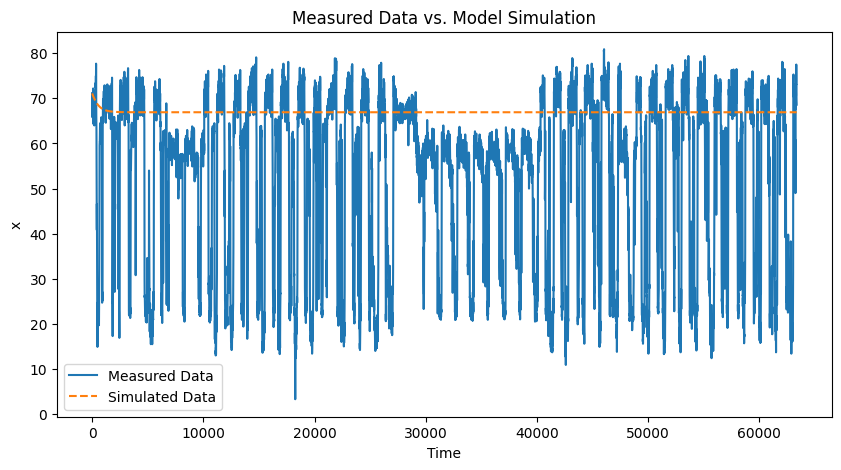

In [5]:
# Simulate the system using the discovered model from the initial condition
x0_initial = x[0]  # first data point as the initial condition
x_sim = model.simulate(x0_initial, t)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(t, x, label='Measured Data')
plt.plot(t, x_sim, '--', label='Simulated Data')
plt.xlabel('Time')
plt.ylabel('x')
plt.title('Measured Data vs. Model Simulation')
plt.legend()
plt.show()




(x0)' = 0.088 1 + 0.191 x0 + -0.194 x1 + 0.015 x2 + -0.015 x3 + -0.001 x0^2 + 0.002 x0 x1 + -0.001 x0 x2 + -0.001 x1 x2 + 0.001 x1 x3 + 0.001 x2^2 + -0.001 x2 x3 + 0.001 x3^2


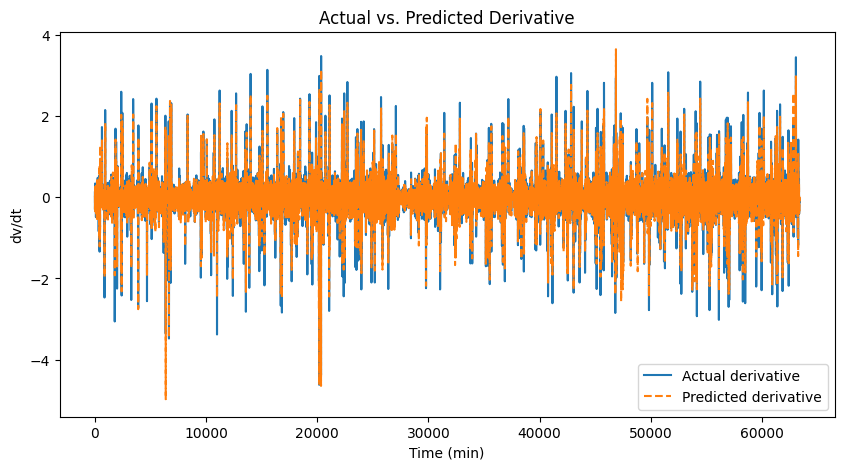

In [ ]:
# Build the delay-embedded state matrix (using 4 columns for delays)
X_state = np.column_stack((
    time_series_sensor_0_5min_step[3:],    # current value: v(t)
    time_series_sensor_0_5min_step[2:-1],   # v(t-1)
    time_series_sensor_0_5min_step[1:-2],   # v(t-2)
    time_series_sensor_0_5min_step[0:-3]    # v(t-3)
))

# Compute the derivative of the current value v(t)
dv = np.gradient(time_series_sensor_0_5min_step[3:], t[3:])

# Now fit the model by providing the state and its derivative separately
import pysindy as ps
import numpy as np
import math
np.math = math  # temporary workaround if needed

optimizer = ps.optimizers.STLSQ(threshold=0.0)  # adjust threshold as desired

model = ps.SINDy(optimizer=optimizer)

# Fit SINDy: X_state is 2D (with 4 columns) and dv is 1D (or 2D with one column)
model.fit(X_state, x_dot=dv, t=t[3:])

# To see the discovered equations:
model.print()

import matplotlib.pyplot as plt

# Predict the derivative using the delay-embedded state X_state
dv_pred = model.predict(X_state)

plt.figure(figsize=(10, 5))
plt.plot(t[3:], dv, label="Actual derivative")
plt.plot(t[3:], dv_pred, '--', label="Predicted derivative")
plt.xlabel("Time (min)")
plt.ylabel("dv/dt")
plt.title("Actual vs. Predicted Derivative")
plt.legend()
plt.show()


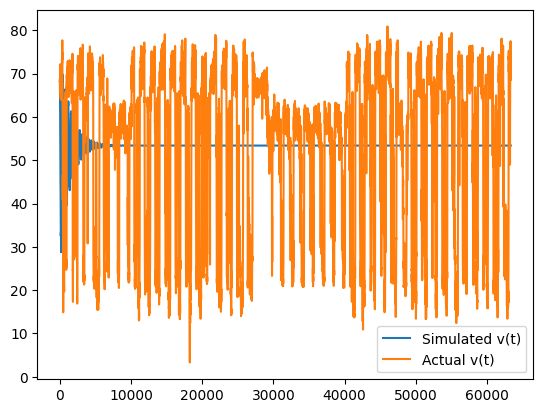

In [7]:
# Build the delay-embedded state matrix (using 4 columns for delays)
X_state = np.column_stack((
    time_series_sensor_0_5min_step[3:],    # current value: v(t)
    time_series_sensor_0_5min_step[2:-1],  # v(t-1)
    time_series_sensor_0_5min_step[1:-2],  # v(t-2)
    time_series_sensor_0_5min_step[0:-3]   # v(t-3)
))

# Compute the derivatives for each column in X_state
x_dot = np.zeros_like(X_state)

# Time slices corresponding to each column's data
time_slices = [
    t[3:],         # for v(t)
    t[2:-1],       # for v(t-1)
    t[1:-2],       # for v(t-2)
    t[0:-3]        # for v(t-3)
]

for i in range(4):
    x_dot[:, i] = np.gradient(X_state[:, i], time_slices[i])

# Fit the model with the correct derivatives
optimizer = ps.optimizers.STLSQ(threshold=0.0001)
model = ps.SINDy(
    optimizer=optimizer,
    feature_names=["v(t)", "v(t-1)", "v(t-2)", "v(t-3)"],    
)
model.fit(X_state, x_dot=x_dot)

# Simulate using the initial state (ensure correct time points for simulation)
initial_state = X_state[0]
# Use the time array starting from t[3] since that's the initial state's time
sim_time = t[3:]  
predict = model.simulate(initial_state, sim_time)

plt.plot(sim_time, predict[:, 0], label='Simulated v(t)')
plt.plot(sim_time, time_series_sensor_0_5min_step[3:], label='Actual v(t)')
plt.legend()
plt.show()